# imports

In [23]:
import pandas as pd
import numpy as np; np.random.seed(0)
import matplotlib.pyplot as plt; plt.rcParams['font.family'] = 'Malgun Gothic'
# import seaborn as sns; sns.set_theme(font='Malgun Gothic')

# from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


pd.set_option('display.max_rows', 100, 'display.max_columns', 100, 'max_colwidth', None)
import warnings; warnings.filterwarnings(action='ignore')

# 숫자 잘린거 다 보여주기
pd.options.display.float_format = '{:.5f}'.format

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300

In [24]:
import statsmodels
statsmodels.__version__ # 0.12.2

'0.12.2'

# read

In [25]:
df = pd.read_csv('./nikkei.csv')

# ARIMA

In [26]:
df['Change']    = df['Close'].pct_change()
df['STDEV']     = df['Close'].rolling(window=20).std(ddof=0)
df['STDEV_log'] = np.log(df['Close'].rolling(window=20).std(ddof=0))
df['HV']        = df['Change'].rolling(window=20, center=False).std() * (252 ** 0.5)

In [27]:
df.tail()

,Date,High,Low,Open,Close,Volume,Adj Close,Change,STDEV_log,STDEV
4610,2021-11-08,29735.44922,29507.05078,29735.44922,29507.05078,68300000.00000,29507.05078,-0.00353,6.12753,0.18085
4611,2021-11-09,29750.46094,29240.31055,29557.55078,29285.46094,65000000.00000,29285.46094,-0.00751,6.10202,0.17693
4612,2021-11-10,29296.88086,29079.76953,29209.06055,29106.77930,63900000.00000,29106.77930,-0.00610,6.00616,0.17464
4613,2021-11-11,29336.02930,29040.08008,29046.18945,29277.85938,60600000.00000,29277.85938,0.00588,5.84104,0.17431
4614,2021-11-12,29661.22070,29381.44922,29381.44922,29609.97070,68400000.00000,29609.97070,0.01134,5.79863,0.17157


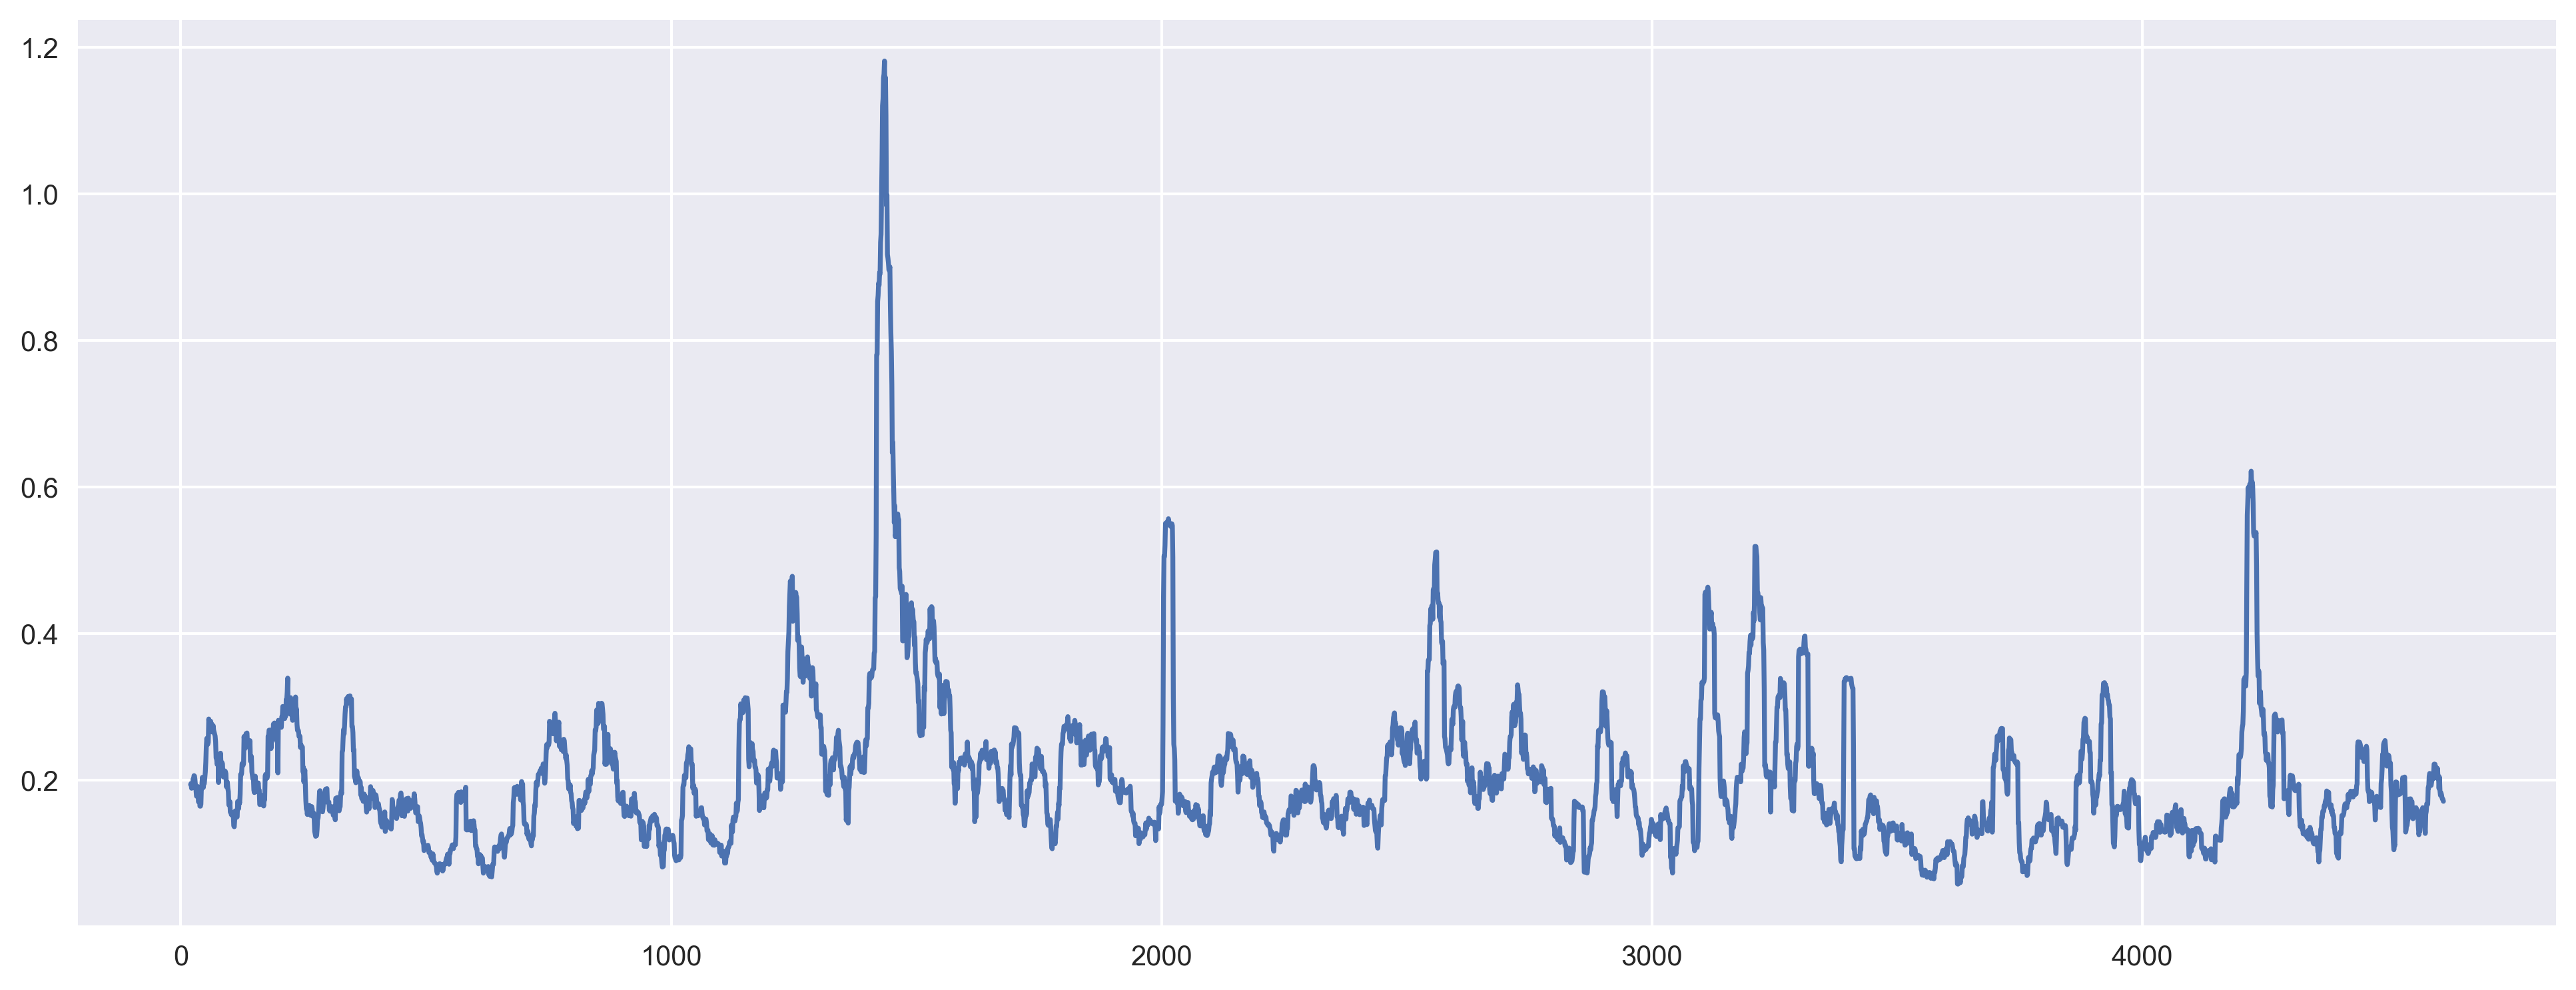

In [28]:
plt.figure(figsize=(16,6))
df['STDEV'].plot() # STDEV_log, HV
plt.show()

In [29]:
# nan 값 삭제
df = df.dropna()

In [30]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Change,STDEV_log,STDEV
20,2003-02-04,8579.41016,8484.90039,8555.73047,8484.90039,59600000.00000,8484.90039,-0.00187,4.84786,0.19454
21,2003-02-05,8574.41992,8423.92969,8425.19043,8549.84961,55400000.00000,8549.84961,0.00765,4.83116,0.19596
22,2003-02-06,8595.23047,8451.20020,8562.28027,8484.19043,48500000.00000,8484.19043,-0.00768,4.83634,0.18934
23,2003-02-07,8517.45020,8422.66992,8482.74023,8448.16016,38300000.00000,8448.16016,-0.00425,4.84788,0.18976
24,2003-02-10,8502.36035,8427.29980,8427.29980,8484.92969,37700000.00000,8484.92969,0.00435,4.84480,0.19008


In [31]:
close_df = df[['Date','STDEV']]
# close_df = df[['Date','STDEV_log']]
# close_df = df[['Date','HV']]

close_df = close_df.sort_values('Date')
close_df = close_df.set_index('Date')

In [32]:
train_df = close_df.loc['2003-09-29':'2020-09-28']    # 2003-9-29 ~ 2020-9-28
test_df = close_df.loc['2020-09-29':'2021-09-28']  # 2020-9-29 ~ 2021-9-28

In [33]:
train_df.tail()

,STDEV
Date,
2020-09-18,0.12511
2020-09-23,0.12502
2020-09-24,0.12228
2020-09-25,0.12383
2020-09-28,0.13181


In [34]:
test_df.tail()

,STDEV
Date,
2021-09-21,0.15391
2021-09-22,0.15756
2021-09-24,0.16816
2021-09-27,0.16847
2021-09-28,0.16745


# Auto Arima

In [35]:
model_arima= auto_arima(train_df, trace=True, error_action='ignore', start_p=1, start_q=1, max_p=4, max_q=4)
model_arima.fit(train_df)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-23074.427, Time=3.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-22882.301, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-22971.440, Time=0.45 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-22953.999, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-22884.282, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-23034.551, Time=2.36 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-23073.014, Time=0.71 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-23002.036, Time=1.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-23031.028, Time=0.38 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-23071.189, Time=1.43 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-23024.412, Time=0.15 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 10.828 seconds


ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True)

In [36]:
tmp_dict = model_arima.to_dict()
tmp_dict['order']

(1, 1, 1)

In [37]:
adfsdfsdf

NameError: name 'adfsdfsdf' is not defined

# ARIMA

In [38]:
model = ARIMA(train_df, order=(1,1,1))

arima_res = model.fit(trend='c', full_output=True, disp=1)
print(arima_res.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.STDEV   No. Observations:                 4156
Model:                 ARIMA(1, 1, 1)   Log Likelihood               11541.216
Method:                       css-mle   S.D. of innovations              0.015
Date:                Mon, 15 Nov 2021   AIC                         -23074.433
Time:                        20:07:29   BIC                         -23049.103
Sample:                             1   HQIC                        -23065.472
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -3.344e-05      0.000     -0.084      0.933      -0.001       0.001
ar.L1.D.STDEV     0.8248      0.028     29.555      0.000       0.770       0.879
ma.L1.D.STDEV    -0.7005      0.035    -

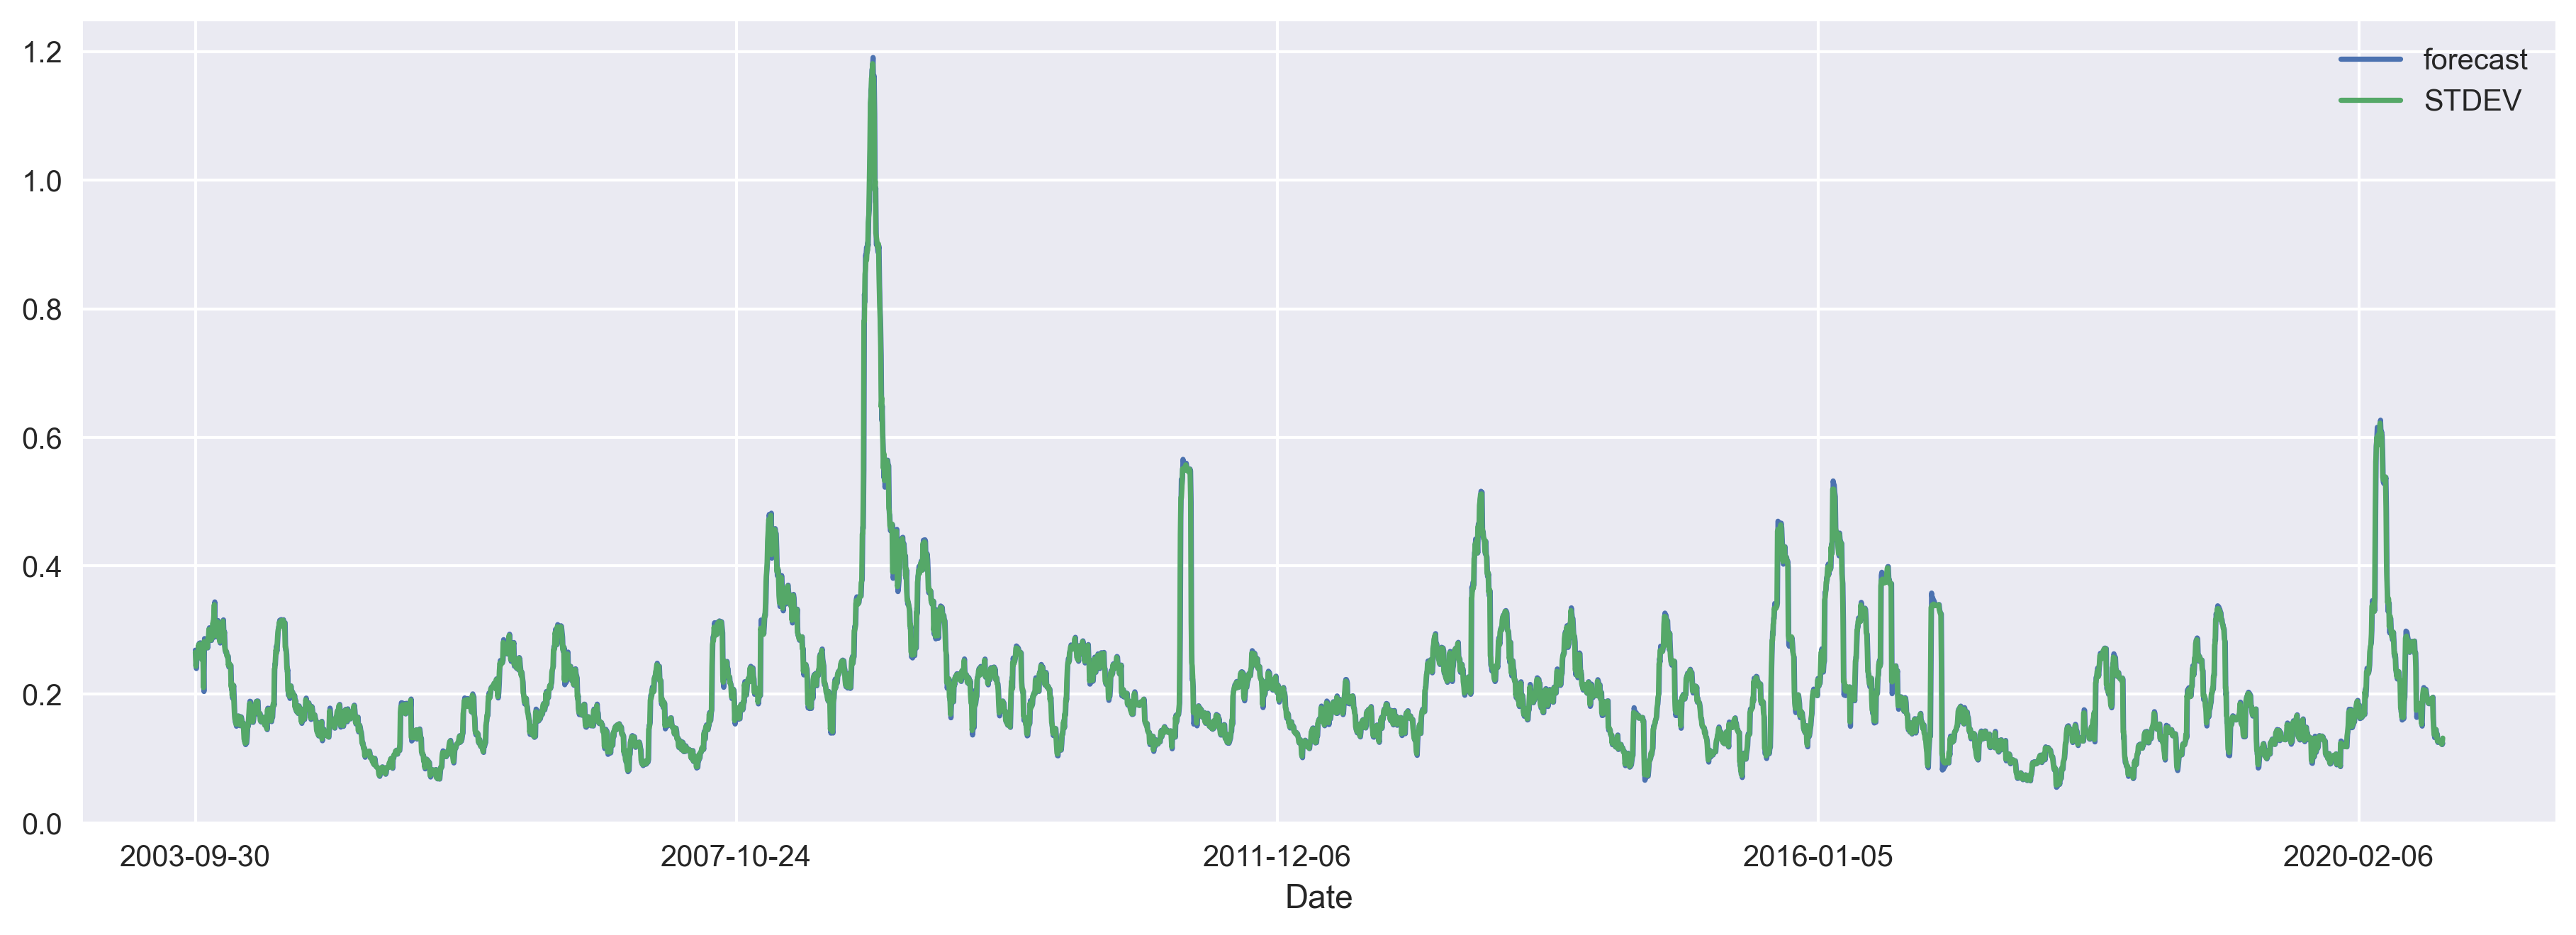

In [39]:
pig, ax = plt.subplots(figsize=(15,5))
arima_res.plot_predict(ax=ax)
plt.show()

# 1년치(2020-9-29 ~ 2021-9-28) 맞추기

In [40]:
forcast_244 = arima_res.forecast(steps=244) # 245: 245일 맞춰봐 
# 예측값, stderr,   upper bound~lower bound
forcast_244 = forcast_244[0]
print(forcast_244)

[0.13262618 0.13329458 0.13383998 0.13428395 0.13464426 0.13493557
 0.13516997 0.13535743 0.13550618 0.13562301 0.1357135  0.13578228
 0.13583314 0.13586923 0.13589314 0.135907   0.13591257 0.1359113
 0.1359044  0.13589285 0.13587746 0.13585891 0.13583775 0.13581444
 0.13578936 0.13576281 0.13573505 0.1357063  0.13567673 0.13564648
 0.13561568 0.13558441 0.13555276 0.1355208  0.13548858 0.13545615
 0.13542354 0.13539079 0.13535791 0.13532494 0.13529189 0.13525877
 0.13522559 0.13519237 0.13515911 0.13512583 0.13509251 0.13505917
 0.13502582 0.13499245 0.13495907 0.13492568 0.13489229 0.13485888
 0.13482547 0.13479206 0.13475864 0.13472522 0.13469179 0.13465837
 0.13462494 0.13459151 0.13455808 0.13452465 0.13449122 0.13445779
 0.13442435 0.13439092 0.13435749 0.13432405 0.13429062 0.13425718
 0.13422375 0.13419031 0.13415688 0.13412344 0.13409001 0.13405657
 0.13402314 0.1339897  0.13395627 0.13392283 0.1338894  0.13385596
 0.13382253 0.13378909 0.13375565 0.13372222 0.13368878 0.13365

In [41]:
len(forcast_244)

244

In [42]:
real = np.array(test_df['STDEV'])
real

array([0.11976115, 0.12733815, 0.12962594, 0.13602563, 0.1330457 ,
       0.12652828, 0.1287036 , 0.12641106, 0.12016686, 0.1167769 ,
       0.11420125, 0.11348305, 0.11332495, 0.12009981, 0.11859061,
       0.11885946, 0.12185562, 0.11424034, 0.11335748, 0.10315087,
       0.10351976, 0.08879256, 0.10189886, 0.10459301, 0.11997755,
       0.1337154 , 0.13336325, 0.15005528, 0.14881956, 0.15795423,
       0.15802086, 0.15819786, 0.16565111, 0.16414513, 0.17060359,
       0.17297396, 0.17085301, 0.18564005, 0.18413024, 0.18305779,
       0.1801443 , 0.1839127 , 0.16671929, 0.16697529, 0.16417929,
       0.16130377, 0.16685014, 0.1564613 , 0.16042494, 0.15273061,
       0.15368938, 0.15111493, 0.13603945, 0.135752  , 0.12752871,
       0.12651767, 0.12522209, 0.10079598, 0.09998075, 0.09649412,
       0.09546986, 0.09400873, 0.12426372, 0.12603261, 0.12917419,
       0.12974533, 0.12713684, 0.13682539, 0.15224589, 0.15134243,
       0.15169585, 0.15278957, 0.15571332, 0.16250462, 0.16713

In [43]:
len(real)

244

# RMSE 확인

In [44]:
from sklearn.metrics import mean_squared_error

mean_squared_error(real, forcast_244, squared=False)

0.0537829295215191